# Comparing a USGSCSM and ISIS camera for MRO CTX

In [1]:
import os 

os.environ["ISISROOT"] = "/usgs/pkgs/isis3.7.0/install"

import pysis
from pysis import isis
from pysis.exceptions import ProcessError

import knoten
from knoten import vis

import json

import ale
from ale import util
from ale.drivers.mro_drivers import MroCtxPds3LabelNaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

/home/kberry/anaconda3/envs/knoten/lib/python3.7/site-packages/ale/__init__.py:22: UserWarning:

ALESPICEROOT environment variable not set, Spice Drivers will not function correctly



## Download Image

In [2]:
url = 'https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG'

!wget -N -P data/ {url}
fileName = 'data/' + os.path.split(url)[1]

--2019-11-01 12:55:25--  https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG
Resolving pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)... 128.149.114.60
Connecting to pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)|128.149.114.60|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘data/K11_057871_1602_XN_19S163W.IMG’ not modified on server. Omitting download.



## Ingest the image into ISIS and attach ALE spice via spiceinit

In [3]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.mroctx2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)

## Create an ISD from the PDS3 .IMG using ISIS cube kernels and store it next to the cube

In [4]:
kernels = ale.util.generate_kernels_from_cube(cub_loc, expand=True)
usgscsm_str = ale.loads(fileName, props={'kernels': kernels}, formatter="usgscsm", verbose=False)

csm_isd = os.path.splitext(cub_loc)[0] + '.json'
with open(csm_isd, 'w') as isd_file:
    isd_file.write(usgscsm_str)

In [5]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

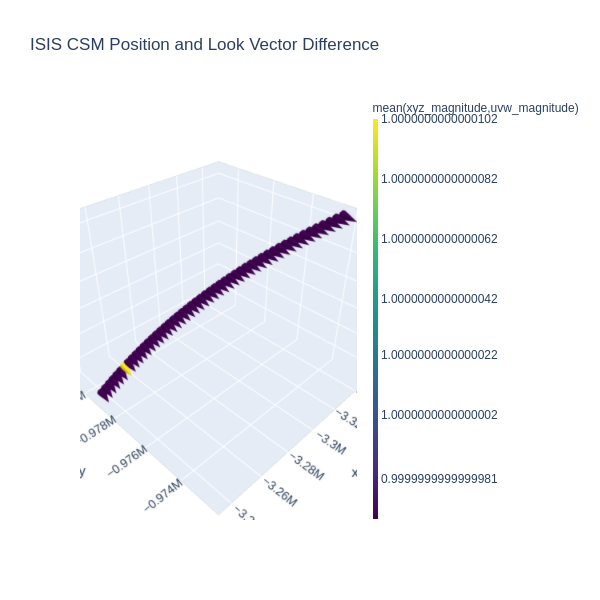

In [6]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

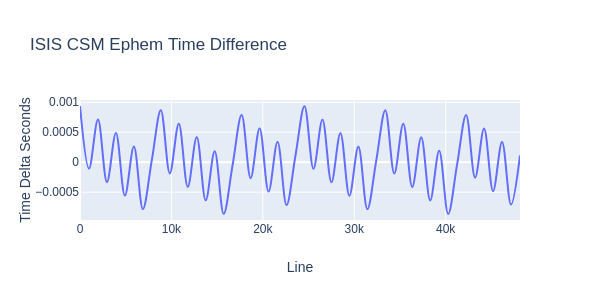

In [7]:
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_ephem_plot_bytes)

In [8]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,500.000000,500.000000,5.000000e+02,5.000000e+02,5.000000e+02
mean,-0.050904,0.000663,0.119188,-3.386020e-06,1.680299e-07,8.912377e-06
std,0.681780,0.032880,1.741306,2.235474e-06,2.235201e-07,5.882477e-06
min,-1.293353,-0.076407,-2.803312,-7.437724e-06,-2.676747e-07,-8.018431e-07
25%,-0.644371,-0.021697,-1.337508,-5.388930e-06,7.346906e-09,3.970980e-06
50%,-0.048156,0.001076,0.120596,-3.324174e-06,1.248215e-07,8.996685e-06
75%,0.543951,0.020832,1.573666,-1.443237e-06,3.147214e-07,1.401730e-05
max,1.118349,0.070093,3.018839,3.395696e-07,6.695342e-07,1.880603e-05


In [9]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 50, 500, 500)

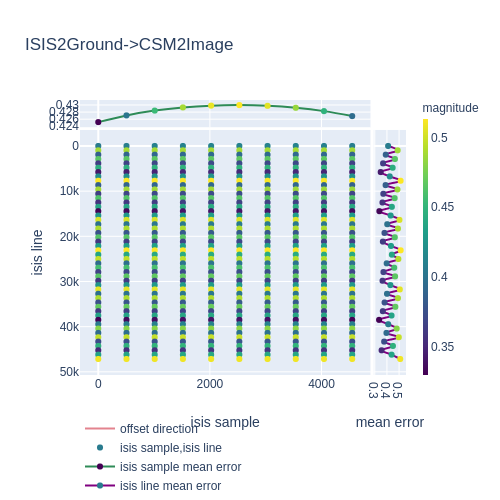

In [10]:
Image(isis2csm_plot.to_image())

In [11]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,0.428247,0.000011
std,0.052432,0.011245
min,0.329687,-0.033053
25%,0.379668,-0.005687
50%,0.432222,0.000055
75%,0.469472,0.006861
max,0.513235,0.033243


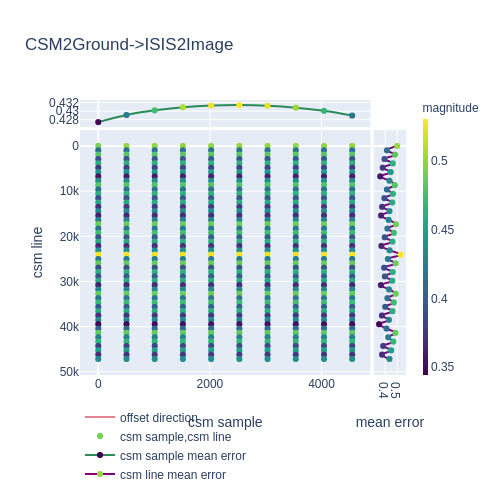

In [12]:
Image(csm2isis_plot.to_image())

In [13]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-0.429993,-0.000597
std,0.042601,0.011004
min,-0.530447,-0.031816
25%,-0.463383,-0.007182
50%,-0.431774,-0.000751
75%,-0.395051,0.004532
max,-0.344252,0.029194


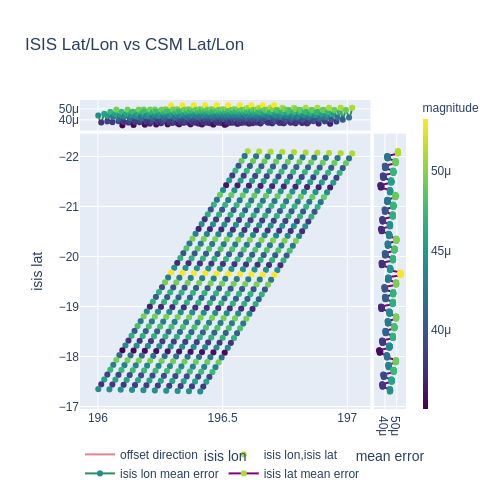

In [14]:
Image(isiscsm_plotlatlon.to_image())

In [15]:
isiscsm_latlondata[['diff lon', 'diff lat']].describe()

,diff lon,diff lat
count,500.000000,500.000000
mean,-0.000005,0.000043
std,0.000001,0.000004
min,-0.000008,0.000035
25%,-0.000006,0.000040
50%,-0.000005,0.000044
75%,-0.000005,0.000047
max,-0.000002,0.000053


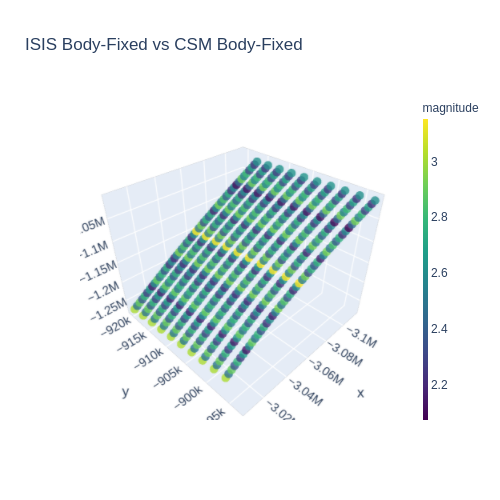

In [16]:
Image(isiscsm_plotbf.to_image())

In [17]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,-1.588525,-0.043162,-2.414391
std,0.023091,0.055619,0.236137
min,-1.643179,-0.167015,-2.933872
25%,-1.600766,-0.080378,-2.603851
50%,-1.588709,-0.042663,-2.429989
75%,-1.573972,-0.007812,-2.207442
max,-1.533346,0.090166,-1.957688
